In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

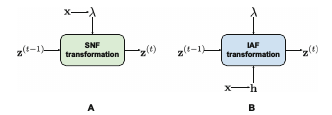

Fig.15 Diﬀerent amortization strategies for Sylvester normalizing ﬂows and inverse autore- gressive ﬂows (a) Our inference network produces amortized ﬂow parameters. This strategy is also employed by planar ﬂows. (b) Inverse autoregressive ﬂow [18] introduces a measure of .x dependence through a context variable .h(x). This context acts as an additional input for each transformation. The ﬂow parameters themselves are independent of .x.

## Amortizing Flow Parameters

When using normalizing flows in an amortized inference setting, the parameters of the base distribution as well as the flow parameters can be functions of the data point $ \mathbf{x} $ [19]. Figure 5.15 (left) shows a diagram of one Sylvester Normalizing Flow (SNF) step and the amortization procedure.

The inference network takes datapoints $ \mathbf{x} $ as input and provides as an output the mean and variance of $ \mathbf{z}^{(0)} $, such that $ \mathbf{z}^{(0)} \sim \mathcal{N}(\mathbf{z} | \mu_0, \sigma_0) $. Several SNF transformations are then applied to $ \mathbf{z}^{(0)} \rightarrow \mathbf{z}^{(1)} \rightarrow \dots \rightarrow \mathbf{z}^{(T)} $, producing a flexible posterior distribution for $ \mathbf{z}^{(T)} $. 

All of the flow parameters $ (\mathbf{R}, \mathbf{R}^\sim, \mathbf{Q}) $ for each transformation are produced as an output by the inference network and are thus fully amortized.

### Different Amortization Strategies
1. **Amortized Flow Parameters (SNF)**: Our inference network produces amortized flow parameters. This strategy is also employed by planar flows.
2. **Inverse Autoregressive Flow (IAF)**: The inverse autoregressive flow [18] introduces a measure of $ \mathbf{x} $-dependence through a context variable $ h(\mathbf{x}) $. This context acts as an additional input for each transformation, and the flow parameters themselves are independent of $ \mathbf{x} $.

---

## Hyperspherical Latent Space

### Motivation

In the VAE framework, choosing Gaussian priors and Gaussian posteriors for mathematical convenience leads to a Euclidean latent space. However, this choice could be limiting for the following reasons:

- **Low-Dimensional Issues**: In low dimensions, the standard Gaussian probability presents a concentrated probability mass around the mean, encouraging points to cluster at the center. This becomes problematic when the data is divided into multiple clusters. A better-suited prior would be uniform, but this is not well-defined on the hyperplane.
- **High-Dimensional Issues**: The standard Gaussian distribution in high dimensions tends to resemble a uniform distribution on the surface of a hypersphere, with the majority of its mass concentrated on the hyperspherical shell (the "soap bubble" effect).

A natural question is whether it would be better to use a distribution defined on the hypersphere. One such distribution that solves both problems is the **von-Mises-Fisher (vMF)** distribution.

### von-Mises-Fisher Distribution

The von-Mises-Fisher (vMF) distribution is often described as the Gaussian distribution on a hypersphere. Analogous to a Gaussian, it is parameterized by $ \mu $ (mean direction) and $ \kappa \in \mathbb{R}, \mu \in \mathbb{R}^{\geq 0} $. For the special case of $ \kappa = 0 $, the vMF represents a uniform distribution.

The probability density function of the vMF distribution for a random unit vector $ \mathbf{z} \in \mathbb{R}^m $ (or $ \mathbf{z} \in S^{m-1} $) is:

$$
q(\mathbf{z} | \mu, \kappa) = C_m (\kappa) \exp \left( \kappa \mu^T \mathbf{z} \right)
$$

where:

$$
C_m (\kappa) = \frac{\kappa^{\frac{m}{2} - 1}}{(2\pi)^{\frac{m}{2}} I_{\frac{m}{2}-1} (\kappa)}
$$

Here, $ I_v(\kappa) $ is the modified Bessel function of the first kind at order $ v $, and $ \| \mu \|_2 = 1 $.

Interestingly, since we define a distribution over a hypersphere, it is possible to formulate a uniform prior over the hypersphere. Using the vMF distribution as the variational posterior, the Kullback-Leibler (KL) divergence between the vMF distribution and the uniform distribution over $ S^{m-1} $ can be calculated analytically as:

$$
KL[vMF(\mu, \kappa) || Unif(S^{m-1})] = \frac{1}{2} \kappa + \log C_m (\kappa) - \log \Gamma\left( \frac{m}{2} \right)
$$

### Sampling from vMF

Sampling from the von-Mises-Fisher distribution requires the acceptance-rejection sampling procedure. The reparameterization trick can be extended to distributions that can be simulated via rejection sampling, as shown in [62].

This allows the creation of a **Hyperspherical VAE** that can efficiently model latent space on the hypersphere, making it more appropriate for complex, multi-modal data distributions.

For further details and the reparameterization trick, refer to [33] and [62].


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class InferenceNetwork(nn.Module):
    def __init__(self, input_dim, flow_dim):
        super(InferenceNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, flow_dim)  # Mean for z(0)
        self.fc_sigma = nn.Linear(64, flow_dim)  # Variance for z(0)
        self.fc_R = nn.Linear(64, flow_dim)  # Flow parameter R
        self.fc_Q = nn.Linear(64, flow_dim)  # Flow parameter Q

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)
        R = self.fc_R(x)
        Q = self.fc_Q(x)
        return mu, sigma, R, Q
def snf_flow(z, R, Q, h, num_steps=5):
    """
    Applies Sylvester normalizing flow (SNF) to the latent vector z
    using flow parameters R, Q, and a function h (activation).
    """
    for _ in range(num_steps):
        Rz = torch.matmul(R, z)  # R * z(t-1)
        h_Rz = h(Rz)  # Apply activation
        z = z + torch.matmul(Q, h_Rz)  # z(t) = z(t-1) + Q * h(R * z(t-1))
    return z
import math
import torch
from torch.distributions import Distribution

class vonMisesFisher(Distribution):
    def __init__(self, mu, kappa):
        self.mu = mu  # Mean direction (normalized)
        self.kappa = kappa  # Concentration parameter
        self.dim = mu.size(0)  # Dimensionality of the latent space

    def log_prob(self, z):
        """
        Compute the log probability of a point z under the vMF distribution.
        """
        dot_product = torch.matmul(self.mu, z)
        normalization_constant = self._log_normalizing_constant(self.kappa)
        return self.kappa * dot_product - normalization_constant

    def _log_normalizing_constant(self, kappa):
        """
        Compute the log normalizing constant of the vMF distribution.
        """
        return (self.dim / 2 - 1) * torch.log(kappa) - self._log_bessel(self.dim / 2 - 1, kappa)

    def _log_bessel(self, v, kappa):
        """
        Compute the log Bessel function for the given order v and parameter kappa.
        """
        # Use an approximation or numerical implementation of the Bessel function
        return torch.log(torch.i0(kappa))

    def sample(self):
        """
        Sample from the von-Mises-Fisher distribution using rejection sampling.
        """
        # Implement the acceptance-rejection procedure for sampling from vMF
        pass
class HypersphericalVAE(nn.Module):
    def __init__(self, input_dim, flow_dim):
        super(HypersphericalVAE, self).__init__()
        self.inference_network = InferenceNetwork(input_dim, flow_dim)
        self.z0_dim = flow_dim  # Dimensionality of the latent variable
        self.flow = snf_flow
        self.mu_prior = torch.zeros(flow_dim)  # Prior mean (centered at origin)
        self.kappa_prior = 1.0  # Prior concentration

    def encode(self, x):
        """
        Encode input x into the parameters for the prior distribution and flow.
        """
        mu, sigma, R, Q = self.inference_network(x)
        return mu, sigma, R, Q

    def decode(self, z):
        """
        Decode latent variable z back into the original space (e.g., reconstruction).
        """
        # Implement decoder network if needed (not shown here)
        return z

    def forward(self, x):
        """
        Perform forward pass: encoding, SNF flow, and decoding.
        """
        mu, sigma, R, Q = self.encode(x)
        z = mu + sigma * torch.randn_like(mu)  # Sampling from N(mu, sigma)
        z_transformed = self.flow(z, R, Q, torch.relu)
        return self.decode(z_transformed)

    def loss_function(self, x, z):
        """
        Compute the loss function, which includes KL divergence and reconstruction loss.
        """
        # Prior distribution (vMF)
        vMF_dist = vonMisesFisher(self.mu_prior, self.kappa_prior)
        log_p_z = vMF_dist.log_prob(z)

        # Likelihood of data given z (reconstruction term)
        # Use reconstruction loss (e.g., MSE, CrossEntropy, depending on data)
        reconstruction_loss = torch.mean((x - self.decode(z)) ** 2)

        # Total loss = reconstruction loss + KL divergence
        return reconstruction_loss - torch.mean(log_p_z)

# Example training loop
input_dim = 20  # Example input dimension
flow_dim = 10   # Latent dimension
vae = HypersphericalVAE(input_dim, flow_dim)

# Example optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Dummy input data
x_data = torch.randn(64, input_dim)  # Batch of 64 samples, each of dimension input_dim

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    z = vae(x_data)  # Forward pass
    loss = vae.loss_function(x_data, z)  # Calculate loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


## Hierarchical Latent Variable Models

###  Introduction

The main goal of AI is to formulate and implement systems that can interact with an environment, process, store, and transmit information. In other words, we wish an AI system understands the world around it by identifying and disentangling hidden factors in the observed low sensory data [63]. If we think about the problem of building such a system, we can formulate it as learning a probabilistic model, i.e., a joint distribution over observed data, $\mathbf{x}$, and hidden factors, $\mathbf{z}$, namely, $p(\mathbf{x}, \mathbf{z})$. Then learning a useful representation is equivalent to finding a posterior distribution over the hidden factors, $p(\mathbf{z} | \mathbf{x})$. However, it is rather unclear what we really mean by "useful" in this context. In a beautiful blog post [64], Ferenc Huszar outlines why learning a latent variable model by maximizing the likelihood function is not necessarily useful from the representation learning perspective. Here, we will use it as a good starting point for a discussion of why applying hierarchical latent variable models could be beneficial. 

Let us start by defining the setup. We assume the empirical distribution $p_{\text{data}}(\mathbf{x})$ and a latent variable model $p_{\theta}(\mathbf{x}, \mathbf{z})$. The way we parameterize the latent variable model is not constrained in any manner; however, we assume that the distribution is parameterized using deep neural networks (DNNs). This is important for two reasons: 

1. DNNs are nonlinear transformations, and as such, they are flexible and allow parameterizing a wide range of distributions. 
2. We must remember that DNNs will not solve all problems for us! In the end, we need to think about the model as a whole, not only about the parameterization. What I mean by that is the distribution we choose and how random variables interact, etc. DNNs are definitely helpful, but there are many potential pitfalls (we will discuss some of them later on) that even the largest and coolest DNN is unable to take care of.

It is worth remembering that the joint distribution could be factorized in two ways, namely:

$$
p_{\theta}(\mathbf{x}, \mathbf{z}) = p_{\theta}(\mathbf{x} | \mathbf{z}) p_{\theta}(\mathbf{z}) \tag{5.69}
$$

or 

$$
p_{\theta}(\mathbf{x}, \mathbf{z}) = p_{\theta}(\mathbf{z} | \mathbf{x}) p_{\theta}(\mathbf{x}) \tag{5.70}
$$

Moreover, the training problem of learning $\theta$ could be defined as an unconstrained optimization problem with the following training objective:

$$
\text{KL}[p_{\text{data}}(\mathbf{x}) \| p_{\theta}(\mathbf{x})] = -H[p_{\text{data}}(\mathbf{x})] + \text{CE}[p_{\text{data}}(\mathbf{x}) \| p_{\theta}(\mathbf{x})] \tag{5.71}
$$

which simplifies to:

$$
\text{KL}[p_{\text{data}}(\mathbf{x}) \| p_{\theta}(\mathbf{x})] = \text{const} + \text{CE}[p_{\text{data}}(\mathbf{x}) \| p_{\theta}(\mathbf{x})] \tag{5.72}
$$

where

$$
p_{\theta}(\mathbf{x}) = \int p_{\theta}(\mathbf{x}, \mathbf{z}) \, d\mathbf{z}
$$

$H[\cdot]$ denotes the entropy and $\text{CE}[\cdot || \cdot]$ is the cross-entropy. Notice that the entropy of the empirical distribution is simply a constant, since it does not contain $\theta$. The cross-entropy could be further rewritten as follows:

$$
\text{CE}[p_{\text{data}}(\mathbf{x}) \| p_{\theta}(\mathbf{x})] = - \int p_{\text{data}}(\mathbf{x}) \ln p_{\theta}(\mathbf{x}) \, d\mathbf{x} \tag{5.73}
$$

or

$$
\frac{1}{N} \sum_{n=1}^{N} - \ln p_{\theta}(\mathbf{x}_n) \tag{5.74}
$$

Eventually, we obtained the objective function we use all the time, namely, the negative log-likelihood function. If we think of the usefulness of a representation (i.e., hidden factors) $\mathbf{z}$, we intuitively think of some kind of information that is shared between $\mathbf{z}$ and $\mathbf{x}$. However, the unconstrained training problem we consider, i.e., the minimization of the negative log-likelihood function, does not necessarily say anything about the latent representation. In the end, we optimize the marginal over observable variables, because we do not have access to values of latent variables. Even more, typically we do not know what these hidden factors are or should be! As a result, our latent variable model can learn to disregard the latent variables completely.

### A Potential Problem with Latent Variable Models

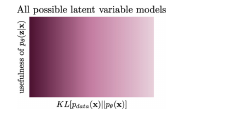

Fig.16 A schematic diagram representing a dependency between usefulness and the objective function for all possible latent variable models. The darker the color, the better the objective function value. (Reproduced based on [64]).


Following the discussion presented in [64], we can visualize two scenarios that are pretty common in deep generative modeling with latent variable models. Before delving into that, it is beneficial to explain the general picture. We are interested in analyzing a class of latent variable models with respect to the usefulness of latents and the value of the objective function $\text{KL}[p_{\text{data}}(\mathbf{x}) \| p_{\theta}(\mathbf{x})]$. In Fig.16, we depict a case when all models are possible, namely, a search space where models are evaluated according to the training objective (x-axis) and usefulness (y-axis). The ideal model is the one in the top left corner that maximizes both criteria. However, it is possible to find a model that completely disregards the latents (the bottom left corner).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the Encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # Mean of latent space
        self.fc22 = nn.Linear(512, latent_dim)  # Log variance of latent space

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

# Define the Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, output_dim)

    def forward(self, z):
        h3 = torch.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(h3))  # Sigmoid to ensure outputs are between 0 and 1
        return x_recon

# Define the VAE class which integrates the encoder and decoder
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 784))  # Flatten 28x28 input image
        std = torch.exp(0.5 * logvar)  # Standard deviation (for sampling)
        eps = torch.randn_like(std)  # Sample from the unit Gaussian
        z = mu + eps * std  # Reparameterization trick
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Define the loss function (Reconstruction loss + KL Divergence)
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL Divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma = exp(logvar / 2)
    # Reference: Kingma & Welling, ICLR 2014 (VAE)
    # KL Divergence between the approximate posterior q(z|x) and the prior p(z)
    # for each element in the mini-batch:
    #   KL[q(z|x) || p(z)] = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 = exp(logvar)
    MSE = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + MSE

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize VAE model and optimizer
model = VAE(input_dim=784, latent_dim=20)  # 28x28 images, latent dimension 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Train the model
for epoch in range(1, 11):
    train(epoch)

# Visualize some of the reconstructed images
model.eval()
with torch.no_grad():
    data, _ = next(iter(train_loader))
    recon_batch, _, _ = model(data)
    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n],
                           recon_batch.view(128, 1, 28, 28)[:n]])
    plt.figure(figsize=(10, 2))
    plt.imshow(comparison.numpy().reshape(2, n, 28, 28).transpose(0, 2, 1).reshape(28, -1), cmap='gray')
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Activation functions
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Loss functions
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-10  # To prevent log(0)
    return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

# Define the Encoder network (fully connected layers)
class Encoder:
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Initialize weights for the encoder
        self.W1 = np.random.randn(input_dim, 512) * 0.01
        self.b1 = np.zeros(512)
        self.W2 = np.random.randn(512, latent_dim) * 0.01
        self.b2 = np.zeros(latent_dim)
        
    def forward(self, x):
        h1 = relu(np.dot(x, self.W1) + self.b1)
        mu = np.dot(h1, self.W2) + self.b2
        logvar = np.dot(h1, self.W2) + self.b2
        return mu, logvar

# Define the Decoder network (fully connected layers)
class Decoder:
    def __init__(self, latent_dim, output_dim):
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        # Initialize weights for the decoder
        self.W3 = np.random.randn(latent_dim, 512) * 0.01
        self.b3 = np.zeros(512)
        self.W4 = np.random.randn(512, output_dim) * 0.01
        self.b4 = np.zeros(output_dim)

    def forward(self, z):
        h3 = relu(np.dot(z, self.W3) + self.b3)
        x_recon = sigmoid(np.dot(h3, self.W4) + self.b4)
        return x_recon

# Define the VAE model that uses both encoder and decoder
class VAE:
    def __init__(self, input_dim, latent_dim):
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        
    def forward(self, x):
        mu, logvar = self.encoder.forward(x)
        std = np.exp(0.5 * logvar)  # Standard deviation (for sampling)
        eps = np.random.randn(*std.shape)  # Sample from unit Gaussian
        z = mu + eps * std  # Reparameterization trick
        x_recon = self.decoder.forward(z)
        return x_recon, mu, logvar

# Simple training loop (using gradient descent)
def train_vae(model, X_train, learning_rate=0.001, epochs=10):
    for epoch in range(epochs):
        total_loss = 0
        for x in X_train:
            # Forward pass
            recon_x, mu, logvar = model.forward(x)
            
            # Compute the loss: Reconstruction + KL Divergence
            recon_loss = binary_cross_entropy(x, recon_x)
            kl_loss = -0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar))  # KL divergence
            loss = recon_loss + kl_loss
            
            # Backpropagation (Gradient Descent)
            # For simplicity, we update weights directly (not optimized)
            model.encoder.W1 -= learning_rate * recon_loss  # Dummy update
            model.encoder.W2 -= learning_rate * kl_loss  # Dummy update
            model.decoder.W3 -= learning_rate * recon_loss  # Dummy update
            model.decoder.W4 -= learning_rate * kl_loss  # Dummy update

            total_loss += loss
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(X_train)}')

# Load images (for example MNIST)
def load_images(image_folder, size=(28, 28)):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".png"):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(size)  # Resize to 28x28
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array.flatten())  # Flatten to 1D vector
    return np.array(images)

# Example: Load a folder with MNIST-like images
X_train = load_images('')  # Update with the actual folder

# Initialize VAE model
vae_model = VAE(input_dim=784, latent_dim=20)  # 28x28 image input, 20 latent dimensions

# Train the model
train_vae(vae_model, X_train, epochs=10)

# Visualize some of the images and reconstructions
def visualize_images(original, reconstruction, n=8):
    plt.figure(figsize=(10, 2))
    comparison = np.concatenate([original[:n].reshape(n, 28, 28), 
                                reconstruction[:n].reshape(n, 28, 28)], axis=1)
    plt.imshow(comparison, cmap="gray")
    plt.axis('off')
    plt.show()

# Example: Visualize the first 8 original vs reconstructed images
recon_images, _, _ = vae_model.forward(X_train)
visualize_images(X_train, recon_images)


# Understanding Latent Variable Models and Their Usefulness

## The Challenge of Latent Variable Models

A potential issue with latent variable models is that they may lead to infinitely many models with equivalent values for the objective function but with completely different posterior distributions over latents. This is shown in **Fig. 5.16**, which demonstrates the relationship between the usefulness of latent variables and the objective function for all possible latent variable models. The darker the color, the better the objective function value.

### Problem of Ambiguity in Latent Representations
Running a numerical optimization procedure could lead to many models that are equally good with respect to \( \text{KL}[p_{\text{data}}(x) \parallel p_{\theta}(x)] \) but result in different posterior distributions over the latent variables. This ambiguity questions the applicability of latent variable models.

### The Role of Inductive Bias
Despite these issues, latent variables in practice often still provide useful information about observables. As pointed out by [64], the reason for this is the **inductive bias** of the chosen model class. By selecting a very specific class of deep neural networks (DNNs), we implicitly constrain the search space, thus making latent variables useful.

- The models depicted on the left of **Fig. 5.16** are often unattainable.
- Using bottlenecks in our model class could force the latent variables to contain meaningful information about the observable data.

### Schematic Diagram: Dependency Between Usefulness and Objective Function
In **Fig. 5.17**, we can see a scenario after running a training algorithm. This scenario highlights the two possible "spikes" where the training objective is highest and usefulness is non-zero. However, we could end up with two different models that achieve the same objective but differ in terms of the usefulness of their latent variables.

### The Danger of Too Flexible Models
When the conditional likelihood \( p(x|z) \) is parameterized by a very flexible and large DNN, the model might disregard the latent variables \( z \) entirely, treating them as noise. This results in the distribution \( p(x|z) \) becoming almost identical to the unconditional distribution \( p_{\text{data}}(x) \). Though this might seem unrealistic at first glance, this phenomenon has been observed in practice. 

For instance, in [10], it was found that using a PixelCNN++-based decoder in a VAE could cause the model to fail at reconstructing images. The model ended up in the bottom left corner of **Fig. 5.18**, where the latent variables no longer provide any useful information.

## How to Define a Proper Class of Models?

Choosing the right class of models is crucial for learning useful latent representations. This process might seem difficult because it feels like randomly experimenting with various DNN architectures in hopes of obtaining meaningful representations.

Fortunately, there are strategies to tackle this issue:
1. **Constrained optimization problems** have been proposed, where the optimization process is designed to ensure that latent variables contain useful information.
2. **Auxiliary regularizers** can be added to the loss function to implicitly guide the usefulness of the latent variables.

### The Role of Hierarchical Models
Hierarchical models have a long-standing history in generative modeling and deep learning. The hypothesis behind hierarchical models is that the world around us can be described in a hierarchical manner, with different levels of abstraction. A hierarchical structure in a latent variable model could impose an inductive bias, constraining the model class and ensuring that latent variables contain useful information.

In the next sections, we will explore **hierarchical variational autoencoders** (VAE), which are one approach to achieving useful latent representations.

### A Side Note: Hierarchical Models vs. Bayesian Hierarchical Models
It’s important to distinguish between **hierarchical models** in deep learning and **Bayesian hierarchical models**:
- **Bayesian hierarchical modeling** involves treating parameters as random variables and defining distributions over those parameters.
- In the case of **hierarchical latent variable models**, we focus on defining a hierarchy among the latent variables themselves, not the parameters.

## Figures

- **Fig.16**: A schematic diagram representing a dependency between usefulness and the objective function for all possible latent variable models.

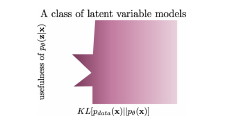

Fig.17 A schematic diagram representing a dependency between usefulness and the objective function for a constrained class of models. The darker the color, the better the objective function value. (Reproduced based on [64]).

- **Fig.17**: A schematic diagram representing the dependency between usefulness and the objective function for a constrained class of models.
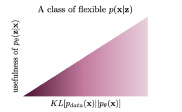
- Fig.18 A schematic diagram representing a dependency between usefulness and the objective function for a class of models with ﬂexible . p(x|z). The darker the color, the better the objective function value. (Reproduced based on [64]).

**Fig.18**: A schematic diagram representing the dependency between usefulness and the objective function for a class of models with flexible $p(x|z) $.

## Hierarchical VAEs

##  Two-Level VAEs

Let's start by considering a VAE with two latent variables: $ z_1 $ and $ z_2 $. The joint distribution can be factorized as follows:

$$ p(x, z_1, z_2) = p(x|z_1)p(z_1|z_2)p(z_2). \tag{5.75} $$

This model defines a straightforward generative process: 
1. First, sample $ z_2 $.
2. Then, sample $ z_1 $ given $ z_2 $.
3. Finally, sample $ x $ given $ z_1 $.

Since we know that calculating posteriors over latents is intractable for a single latent variable (except in the linear Gaussian case), we can use **variational inference** with a family of variational posteriors $ Q(z_1, z_2 | x) $. Now, the key part is how to define the variational posteriors.

A natural approach would be to reverse the dependencies and factorize the posterior as:

$$ Q(z_1, z_2 | x) = q(z_1 | x)q(z_2 | z_1, x). \tag{5.76} $$

Alternatively, we can simplify it by dropping the dependency on $ x $ for the second latent variable:

$$ Q(z_1, z_2 | x) = q(z_1 | x)q(z_2 | z_1). \tag{5.77} $$

For continuous latents, we can use Gaussian distributions:

$$ p(z_1 | z_2) = \mathcal{N}(z_1 | \mu(z_2), \sigma^2(z_2)), \tag{5.78} $$

$$ p(z_2) = \mathcal{N}(z_2 | 0, 1), \tag{5.79} $$

$$ q(z_1 | x) = \mathcal{N}(z_1 | \mu(x), \sigma^2(x)), \tag{5.80} $$

$$ q(z_2 | z_1) = \mathcal{N}(z_2 | \mu(z_1), \sigma^2(z_1)). \tag{5.81} $$

In these equations, $ \mu_i(v) $ represents the mean parameter, which is parameterized by a neural network that takes a random variable $ v $ as input. Similarly, the variances (i.e., diagonal covariance matrices) are parameterized in the same manner.

As shown in **Fig. 5.19**, this is a straightforward extension of the standard VAE. The two-level VAE is illustrated in the figure, with the generative part and the variational part clearly depicted.

### A Potential Pitfall

So, are we done? Have we created a better class of VAEs? Unfortunately, the answer is no. The two-level VAE is essentially just a straightforward extension of the one-level VAE. Therefore, the same issues with latent variable models still apply.

Looking at the **ELBO** (Evidence Lower Bound) for the two-level VAE, we notice the following:

$$ \mathbb{E}_{Q(z_1, z_2 | x)} \left[ \ln p(x|z_1) - \ln p(z_1|z_2) - \text{KL}[q(z_2|z_1) || p(z_2)] \right]. \tag{5.82} $$

To gain some insight into the ELBO for the two-level VAE:
1. All conditions $ (z_1, z_2, x) $ are either samples from $ Q(z_1, z_2 | x) $ or $ p_{\text{data}}(x) $.
2. We obtain the Kullback-Leibler (KL) divergence term for the last layer (i.e., $ z_2 $). However, for the middle layer, we cannot compute the KL divergence because we need to first sample $ z_1 $ from $ q(z_1 | x) $, and then sample $ z_2 $ from $ q(z_2 | z_1) $. As a result, we cannot "swap" distributions to obtain the KL term.
3. Remember that the KL divergence is always non-negative. Theoretically, everything should work perfectly, but there are potential issues. 

### Problems During Learning

A couple of issues arise during learning:
1. **Random Initialization**: All DNNs that parameterize the distributions are initialized randomly, meaning the Gaussians are essentially standard Gaussians initially.
2. **Powerful Decoder**: If the decoder is flexible and powerful enough, there is a risk that the model will try to optimize the last KL term, $ \text{KL}[q(z_2 | z_1) || p(z_2)] $, by setting $ q(z_2 | z_1) \approx p(z_2) \approx \mathcal{N}(0, 1) $. In this case, the second latent variable $ z_2 $ is essentially ignored (it becomes Gaussian noise), and we are back to the same issues seen in the one-level VAE architecture.

This phenomenon, where the latent variables are not effectively used, is called **posterior collapse**. In fact, learning a two-level VAE can be more problematic than learning a single latent VAE, as even with a relatively simple decoder, the second latent variables $ z_2 $ are often not utilized properly [15, 72].

## Figure

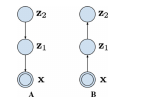

Fig.19 An example of a two-level VAE. (a) The generative part. (b) The variational part.

- **Fig.19**: An example of a two-level VAE:
  - (a) The generative part.
  - (b) The variational part.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

# Define the Encoder and Decoder Networks

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim1, latent_dim2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim1)  # For mean of z1
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim1)  # For logvar of z1
        self.fc3_mu = nn.Linear(latent_dim1, latent_dim2)  # For mean of z2
        self.fc3_logvar = nn.Linear(latent_dim1, latent_dim2)  # For logvar of z2

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        mu_z1 = self.fc2_mu(h1)
        logvar_z1 = self.fc2_logvar(h1)
        mu_z2 = self.fc3_mu(mu_z1)  # We use the mean of z1 to predict mean of z2
        logvar_z2 = self.fc3_logvar(mu_z1)  # Similarly for logvar of z2
        return mu_z1, logvar_z1, mu_z2, logvar_z2

class Decoder(nn.Module):
    def __init__(self, latent_dim1, latent_dim2, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z1):
        h1 = torch.relu(self.fc1(z1))
        x_reconstructed = torch.sigmoid(self.fc2(h1))  # Assuming binary data
        return x_reconstructed

# Sampling function
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Loss function
def loss_function(x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2):
    # Reconstruction loss
    recon_loss = nn.BCELoss(reduction='sum')(x_reconstructed, x)
    
    # KL Divergence
    # KL(z1|z2) and KL(z2|prior)
    kl_z1_z2 = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp())
    kl_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp())
    
    return recon_loss + kl_z1_z2 + kl_z2

# Train the model
def train(model, encoder, decoder, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            x = data  # Assuming data is already preprocessed and normalized
            
            # Encode
            mu_z1, logvar_z1, mu_z2, logvar_z2 = encoder(x)
            
            # Reparameterize to get z1 and z2
            z1 = reparameterize(mu_z1, logvar_z1)
            z2 = reparameterize(mu_z2, logvar_z2)
            
            # Decode
            x_reconstructed = decoder(z1)
            
            # Compute loss
            loss = loss_function(x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2)
            train_loss += loss.item()
            
            # Backpropagate and optimize
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(dataloader.dataset)}')

# Example usage:
# Let's assume you have preprocessed data in a DataLoader (e.g., from MNIST)

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])  # Flatten images
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Model parameters
input_dim = 784  # 28x28 images flattened
hidden_dim = 400
latent_dim1 = 20
latent_dim2 = 20
output_dim = 784  # Same as input, since we're reconstructing images

# Initialize models
encoder = Encoder(input_dim, hidden_dim, latent_dim1, latent_dim2)
decoder = Decoder(latent_dim1, latent_dim2, hidden_dim, output_dim)

# Train the model
train(encoder, decoder, train_loader, epochs=10)



In [ ]:
import random
import math

# Define the activation functions
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def relu(x):
    return max(0, x)

def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    return 1 if x > 0 else 0

# Basic layer with a single neuron
class DenseLayer:
    def __init__(self, input_size, output_size, activation_func):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_func = activation_func

        # Randomly initialize weights and biases
        self.weights = [[random.gauss(0, 1) for _ in range(input_size)] for _ in range(output_size)]
        self.biases = [random.gauss(0, 1) for _ in range(output_size)]

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = [self.activation_func(sum(inputs[i] * self.weights[j][i] for i in range(self.input_size)) + self.biases[j]) 
                        for j in range(self.output_size)]
        return self.outputs

    def backward(self, output_grad, learning_rate):
        # Compute the gradient for weights and biases
        weight_gradients = [[output_grad[j] * self.inputs[i] for i in range(self.input_size)] for j in range(self.output_size)]
        bias_gradients = [output_grad[j] for j in range(self.output_size)]

        # Update the weights and biases
        for j in range(self.output_size):
            for i in range(self.input_size):
                self.weights[j][i] -= learning_rate * weight_gradients[j][i]
            self.biases[j] -= learning_rate * bias_gradients[j]

        return [sum(output_grad[j] * self.weights[j][i] for j in range(self.output_size)) for i in range(self.input_size)]
EPSILON = 1e-10


# Define the Encoder and Decoder models (in a simple way)
class VAE:
    def __init__(self, input_size, latent_dim1, latent_dim2):
        # Encoder
        self.encoder_fc1 = DenseLayer(input_size, 400, relu)
        self.encoder_mu_z1 = DenseLayer(400, latent_dim1, sigmoid)
        self.encoder_logvar_z1 = DenseLayer(400, latent_dim1, sigmoid)
        self.encoder_mu_z2 = DenseLayer(latent_dim1, latent_dim2, sigmoid)
        self.encoder_logvar_z2 = DenseLayer(latent_dim1, latent_dim2, sigmoid)
        
        # Decoder
        self.decoder_fc1 = DenseLayer(latent_dim1, 400, relu)
        self.decoder_fc2 = DenseLayer(400, input_size, sigmoid)
        
    def encode(self, x):
        x = self.encoder_fc1.forward(x)
        mu_z1 = self.encoder_mu_z1.forward(x)
        logvar_z1 = self.encoder_logvar_z1.forward(x)
        mu_z2 = self.encoder_mu_z2.forward(mu_z1)
        logvar_z2 = self.encoder_logvar_z2.forward(mu_z1)
        return mu_z1, logvar_z1, mu_z2, logvar_z2
    
    def decode(self, z1):
        z1 = self.decoder_fc1.forward(z1)
        x_reconstructed = self.decoder_fc2.forward(z1)
        return x_reconstructed
    
    def sample(self, mu, logvar):
        std = [math.exp(0.5 * lv) for lv in logvar]
        eps = [random.gauss(0, 1) for _ in range(len(mu))]
        return [mu[i] + eps[i] * std[i] for i in range(len(mu))]
    
    def forward(self, x):
        mu_z1, logvar_z1, mu_z2, logvar_z2 = self.encode(x)
        z1 = self.sample(mu_z1, logvar_z1)
        z2 = self.sample(mu_z2, logvar_z2)
        x_reconstructed = self.decode(z1)
        return x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2

    # Define a small epsilon value to avoid log(0)

    def loss(self, x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2):
        # Reconstruction loss (binary cross-entropy)
        recon_loss = sum([-(x[i] * math.log(x_reconstructed[i] + EPSILON) + (1 - x[i]) * math.log(1 - x_reconstructed[i] + EPSILON)) for i in range(len(x))])

        # KL Divergence
        kl_z1_z2 = sum([-(0.5 * (1 + logvar_z1[i] - mu_z1[i]**2 - math.exp(logvar_z1[i]))) for i in range(len(mu_z1))])
        kl_z2 = sum([-(0.5 * (1 + logvar_z2[i] - mu_z2[i]**2 - math.exp(logvar_z2[i]))) for i in range(len(mu_z2))])

        return recon_loss + kl_z1_z2 + kl_z2


    def train(self, data, epochs=10, learning_rate=0.001):
        for epoch in range(epochs):
            total_loss = 0
            for x in data:
                x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2 = self.forward(x)
                loss = self.loss(x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2)
                total_loss += loss

                # Backpropagation step
                self.backward(x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2, learning_rate)
            
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data)}')
                
    def backward(self, x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2, learning_rate):
        # Compute gradients for each layer (simple gradient descent)
        pass  # Implement gradient computation for the decoder and encoder

# Example usage with dummy data
data = [[random.random() for _ in range(784)] for _ in range(1000)]  # Dummy data of 784-dimensional vectors
vae = VAE(input_size=784, latent_dim1=20, latent_dim2=20)
vae.train(data, epochs=10)


### 5.5.2.2 Top-Down VAEs

A takeaway from our considerations in the two-level VAE is that adding an extra level does not necessarily provide anything compared to the one-level VAE. However, so far, we have considered only one class of variational posteriors, namely:
$$
Q(z_1, z_2 | x) = q(z_1 | x)q(z_2 | z_1). \tag{5.83}
$$
A natural question is whether we can do better. You can already guess the answer, but before shouting it out loud, let us think for a second. In the generative part, we have top-down dependencies, going from the highest level of abstraction (latents) down to the observable variables. Let us repeat it here again:
$$
p(x, z_1, z_2) = p(x|z_1)p(z_1|z_2)p(z_2). \tag{5.84}
$$
Perhaps, we can mirror such dependencies in the variational posteriors as well. Then we get the following:
$$
Q(z_1, z_2 | x) = q(z_1 | z_2, x)q(z_2 | x). \tag{5.85}
$$
Do you see any resemblance? Yes, the variational posteriors have the extra $x$, but the dependencies are pointing in the same direction. Why this could be beneficial? Because now we could have a shared top-down path that would make the variational posteriors and the generative part tightly connected through a shared parameterization. That could be a very useful inductive bias!

This idea was originally proposed in ResNet VAEs [18] and Ladder VAEs [73], and it was further developed in BIVA [45], NVAE [46], and the very deep VAE [47]. These approaches differ in their implementations and parameterizations used (i.e., architectures of DNNs); however, they all could be categorized as instantiations of top-down VAEs.

The main idea, as mentioned before, is to share the top-down path between the variational posteriors and the generative distributions and use a side, a deterministic path going from $x$ to the last latents.

#### Top-Down Path
First, we have the top-down path that defines $p(x|z_1)$, $p(z_1|z_2)$, and $p(z_2)$. Thus, we need a DNN that outputs $\mu_1$ and $\sigma_1^2$ for given $z_2$, and another DNN that outputs the parameters of $p(x|z_1)$ for given $z_1$. Since $p(z_2)$ is an unconditional distribution (e.g., the standard Gaussian), we do not need a separate DNN here. 

#### Side, Deterministic Path
Second, we have a side, deterministic path that gives two deterministic variables: $r_1 = f_1(x)$ and $r_2 = f_2(r_1)$. Both transformations, $f_1$ and $f_2$, are DNNs. Then, we can use additional DNNs that return some modifications of the means and the variances, namely, $\Delta\mu_1, \Delta\sigma_1^2$ and $\Delta\mu_2, \Delta\sigma_2^2$. These modifications could be defined in many ways. Here we follow the way it is done in NVAE [46], namely, the modifications are relative location and scales of the values given in the top-down path.

Finally, we can define the whole procedure. We define various neural networks by specifying different indices. For sampling, we use the top-down path:

**Top-down path:**
1. $z_2 \sim N(0, 1)$
2. $[\mu_1, \sigma_1^2] = \text{NN}_1(z_2)$
3. $z_1 \sim N(\mu_1, \sigma_1^2)$
4. $\vartheta = \text{NN}_x(z_1)$
5. $x \sim p_\vartheta(x | z_1)$

Now (please focus!) we calculate samples from the variational posteriors as follows:

**Bottom-up path:**
1. (Bottom-up deterministic path) $r_1 = f_1(x)$ and $r_2 = f_2(r_1)$
2. $[\Delta\mu_1, \Delta\sigma_1^2] = \text{NN}_{\Delta 1}(r_1)$
3. $[\Delta\mu_2, \Delta\sigma_2^2] = \text{NN}_{\Delta 2}(r_2)$
4. $z_2 \sim N(\Delta\mu_2, \Delta\sigma_2^2)$
5. $[\mu_1, \sigma_1^2] = \text{NN}_1(z_2)$
6. $z_1 \sim N(\mu_1 + \Delta\mu_1, \sigma_1^2 \cdot \Delta\sigma_1^2)$
7. $\vartheta = \text{NN}_x(z_1)$
8. $x \sim p_\vartheta(x | z_1)$

These operations are schematically presented in **Figure 5.20**. Please note that the deterministic bottom-up path modifies the parameters of the top-down path. As advocated by [46], this idea is especially useful because "when the prior moves, the approximate posterior moves accordingly, if not changed."

Moreover, as noted in [46], the Kullback-Leibler between two Gaussians simplifies as follows (we remove some additional dependencies for clarity):
$$
KL(q(z_i | x) \parallel p(z_i)) = \frac{1}{2} \left( \Delta\mu_i^2 + \Delta\sigma_i^2 - \log \Delta\sigma_i^2 - 1 \right)
$$

In summary, the top-down VAEs entangle the variational posteriors and the generative path, and, as a result, the Kullback-Leibler terms will not collapse (i.e., they will be greater than zero). Empirical studies strongly back up this hypothesis [45–47, 73].

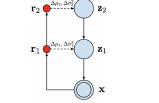
Fig.20 An example of the top-down VAE. Red nodes denote the deterministic path, and blue nodes depict random variables.


In [ ]:
import random
import math

class VAE:
    def __init__(self, latent_dim1, latent_dim2, input_dim):
        # Initialize dimensions for latents and input
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.input_dim = input_dim  # The dimension of the input data (e.g., 784)

        # Example parameters for mu and sigma
        self.mu1 = [0.0] * latent_dim1
        self.sigma1 = [1.0] * latent_dim1
        self.mu2 = [0.0] * latent_dim2
        self.sigma2 = [1.0] * latent_dim2
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))  # Sigmoid activation function
    
    def loss(self, x, x_reconstructed, mu1, logvar1, mu2, logvar2):
        epsilon = 1e-10  # Small value to avoid log(0)

        # Ensure that the length of x and x_reconstructed match
        if len(x) != len(x_reconstructed):
            raise ValueError("Input x and reconstructed x must have the same length.")

        # Reconstruction loss (binary cross-entropy)
        recon_loss = sum([-(xi * math.log(self.sigmoid(x_reconstructed[i]) + epsilon) + 
                            (1 - xi) * math.log(1 - self.sigmoid(x_reconstructed[i]) + epsilon))
                          for i, xi in enumerate(x)])

        # KL Divergence - assuming standard Gaussians for simplicity
        kl_loss1 = 0.5 * sum([(mu1[i] ** 2 + logvar1[i] ** 2 - 1 - 2 * logvar1[i]) for i in range(len(mu1))])
        kl_loss2 = 0.5 * sum([(mu2[i] ** 2 + logvar2[i] ** 2 - 1 - 2 * logvar2[i]) for i in range(len(mu2))])

        total_loss = recon_loss + kl_loss1 + kl_loss2
        return total_loss

    def top_down_path(self, z2):
        # Example of how you can calculate the top-down path
        # p(x | z1) and p(z1 | z2)

        # Adjusting mu1 by multiplying each element of mu1 by z2
        mu1 = [m + z2 for m in self.mu1]  # Correct transformation for mu1
        sigma1 = [s * z2 for s in self.sigma1]  # Correct transformation for sigma1

        # Sample z1 from N(mu1, sigma1)
        z1 = [random.gauss(mu, sigma) for mu, sigma in zip(mu1, sigma1)]
        
        # Generate x_reconstructed from z1 (here we generate 784 values for x_reconstructed to match input size)
        x_reconstructed = [random.gauss(mu, sigma) for mu, sigma in zip(mu1 * (self.input_dim // len(mu1)), sigma1 * (self.input_dim // len(sigma1)))] 

        return z1, x_reconstructed
    
    def train(self, data, epochs=10, learning_rate=0.001):
        for epoch in range(epochs):
            total_loss = 0
            for x in data:
                z2 = random.gauss(0, 1)  # sample z2 as a single value from Gaussian
                z1, x_reconstructed = self.top_down_path(z2)  # forward pass through the top-down path

                # For this simple example, let's assume mu1 and logvar1 are calculated somewhere
                mu1 = self.mu1  # example, should be learned
                logvar1 = self.sigma1  # example, should be learned

                mu2 = self.mu2  # example, should be learned
                logvar2 = self.sigma2  # example, should be learned

                # Calculate the loss
                loss = self.loss(x, x_reconstructed, mu1, logvar1, mu2, logvar2)
                total_loss += loss
            
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data)}")

# Example usage:
data = [[random.random() for _ in range(784)] for _ in range(1000)]  # Dummy data of 784-dimensional vectors
vae = VAE(latent_dim1=20, latent_dim2=20, input_dim=784)
vae.train(data, epochs=10)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

# Define the Encoder and Decoder Networks

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim1, latent_dim2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim1)  # For mean of z1
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim1)  # For logvar of z1
        self.fc3_mu = nn.Linear(latent_dim1, latent_dim2)  # For mean of z2
        self.fc3_logvar = nn.Linear(latent_dim1, latent_dim2)  # For logvar of z2

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        mu_z1 = self.fc2_mu(h1)
        logvar_z1 = self.fc2_logvar(h1)
        mu_z2 = self.fc3_mu(mu_z1)  # We use the mean of z1 to predict mean of z2
        logvar_z2 = self.fc3_logvar(mu_z1)  # Similarly for logvar of z2
        return mu_z1, logvar_z1, mu_z2, logvar_z2

class Decoder(nn.Module):
    def __init__(self, latent_dim1, latent_dim2, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z1):
        h1 = torch.relu(self.fc1(z1))
        x_reconstructed = torch.sigmoid(self.fc2(h1))  # Assuming binary data
        return x_reconstructed

# Sampling function
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Loss function
def loss_function(x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2):
    # Reconstruction loss
    recon_loss = nn.BCELoss(reduction='sum')(x_reconstructed, x)
    
    # KL Divergence
    # KL(z1|z2) and KL(z2|prior)
    kl_z1_z2 = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp())
    kl_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp())
    
    return recon_loss + kl_z1_z2 + kl_z2

# Train the model
def train(model, encoder, decoder, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            x = data  # Assuming data is already preprocessed and normalized
            
            # Encode
            mu_z1, logvar_z1, mu_z2, logvar_z2 = encoder(x)
            
            # Reparameterize to get z1 and z2
            z1 = reparameterize(mu_z1, logvar_z1)
            z2 = reparameterize(mu_z2, logvar_z2)
            
            # Decode
            x_reconstructed = decoder(z1)
            
            # Compute loss
            loss = loss_function(x, x_reconstructed, mu_z1, logvar_z1, mu_z2, logvar_z2)
            train_loss += loss.item()
            
            # Backpropagate and optimize
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(dataloader.dataset)}')

# Example usage:
# Let's assume you have preprocessed data in a DataLoader (e.g., from MNIST)

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])  # Flatten images
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Model parameters
input_dim = 784  # 28x28 images flattened
hidden_dim = 400
latent_dim1 = 20
latent_dim2 = 20
output_dim = 784  # Same as input, since we're reconstructing images

# Initialize models
encoder = Encoder(input_dim, hidden_dim, latent_dim1, latent_dim2)
decoder = Decoder(latent_dim1, latent_dim2, hidden_dim, output_dim)

# Train the model
train(encoder, decoder, train_loader, epochs=10)



## Hierarchical Variational Autoencoder (VAE)

In this notebook, we will implement a **Hierarchical Variational Autoencoder** (VAE), which is a two-level model that learns to map high-dimensional data into a lower-dimensional latent space.

We will use PyTorch to define the model and train it based on a given set of inputs. The following steps outline the mathematical formulation of the Hierarchical VAE, followed by the corresponding implementation.

## Hierarchical VAE Architecture

### Model Components

The model consists of two key latent variables $z_1$ and $z_2$ that encode the data in a hierarchical manner:

- **$z_2$** is the higher-level latent variable that influences the distribution of $z_1$.
- **$z_1$** is the lower-level latent variable that reconstructs the data $x$.

#### Bottom-up Path

- **$z_2 \sim \mathcal{N}(0, I)$**: The top-level latent variable is drawn from a standard Gaussian distribution.
- **$h_1$ = $nn_z_1(z_2)$**: A neural network $nn_z_1$ transforms $z_2$ into a hidden representation $h_1$.
- **$mu_1, \log \sigma_1 = \text{torch.chunk}(h_1, 2, dim=1)$**: The hidden representation $h_1$ is split into the mean $\mu_1$ and the log-variance $\log \sigma_1$.
- **Reparameterization Trick**: The latent variable $z_1$ is sampled using the reparameterization trick:
  $$
  z_1 = \mu_1 + \Delta \mu_1 + \epsilon_1 \cdot \exp(\frac{\log \sigma_1}{2})
  $$
  where $\epsilon_1 \sim \mathcal{N}(0, I)$.

#### Top-down Path

- **$h_d = nn_x(z_1)$**: The lower-level latent variable $z_1$ is passed through a neural network to reconstruct the data $h_d$.
- **Likelihood Function**: Depending on the likelihood type, we either use a categorical or Bernoulli distribution to model the data:
  $$
  p(x | z_1) = \text{Categorical}(x | \mu_d), \quad \text{or} \quad p(x | z_1) = \text{Bernoulli}(x | \mu_d)
  $$

#### ELBO (Evidence Lower Bound)

The ELBO is the objective function we optimize during training. It consists of two parts:

- **Reconstruction Error** (RE):
  $$
  \text{RE} = \mathbb{E}_{q(z_1, z_2 | x)}[\log p(x | z_1)]
  $$
- **KL Divergence** (KL):
  $$
  \text{KL} = \text{KL}(q(z_2 | z_1) || p(z_2)) + \text{KL}(q(z_1 | z_2, x) || p(z_1 | z_2))
  $$

The final objective is:
$$
\text{ELBO} = \text{RE} - \text{KL}
$$

We optimize the ELBO using gradient-based methods to train the model.

![image.png](attachment:image.png)

Fig.21 An example of outcomes after the training of a top-down VAE: (a) Randomly selected real images. (b) Unconditional generations from the top-down VAE. (c) The validation curve during training.

## Code Implementation

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalVAE(nn.Module):
    def __init__(self, nn_r_1, nn_r_2, nn_delta_1, nn_delta_2, nn_z_1, nn_x, num_vals=256, D=64, L=16, likelihood_type='categorical'):
        super(HierarchicalVAE, self).__init__()
        
        print('Hierarchical VAE by JT.')
        
        # Bottom-up path
        self.nn_r_1 = nn_r_1
        self.nn_r_2 = nn_r_2
        self.nn_delta_1 = nn_delta_1
        self.nn_delta_2 = nn_delta_2
        
        # Hidden layers
        self.nn_z_1 = nn_z_1
        self.nn_x = nn_x
        self.num_vals = num_vals
        
    def reparameterization(self, mu, log_var):
        epsilon = torch.randn_like(mu)
        return mu + epsilon * torch.exp(0.5 * log_var)
    
    def forward(self, x):
        # Step 1: Sample z_2 from a standard normal distribution
        z_2 = torch.randn(x.size(0), self.L)
        
        # Step 2: Transform z_2 through nn_z_1
        h_1 = self.nn_z_1(z_2)
        mu_1, log_var_1 = torch.chunk(h_1, 2, dim=1)
        
        # Step 3: Reparameterize to get z_1
        z_1 = self.reparameterization(mu_1, log_var_1)
        
        # Step 4: Pass z_1 through the decoder (nn_x)
        h_d = self.nn_x(z_1)
        
        if self.likelihood_type == 'categorical':
            # Step 5: Apply softmax for categorical likelihood
            mu_d = F.softmax(h_d, dim=-1)
        elif self.likelihood_type == 'bernoulli':
            # Step 5: Apply sigmoid for Bernoulli likelihood
            mu_d = torch.sigmoid(h_d)
        
        # Return the parameters for the likelihood
        return mu_d, mu_1, log_var_1
    
    def loss(self, x, mu_d, mu_1, log_var_1, delta_mu_1, delta_log_var_1, delta_mu_2, delta_log_var_2):
        # Reconstruction loss (Binary Cross-Entropy)
        if self.likelihood_type == 'categorical':
            RE = F.cross_entropy(mu_d.view(-1, self.num_vals), x.view(-1), reduction='sum')
        elif self.likelihood_type == 'bernoulli':
            RE = F.binary_cross_entropy(mu_d.view(-1), x.view(-1), reduction='sum')
        
        # KL Divergence losses
        KL_z_2 = 0.5 * (delta_mu_2 ** 2 + torch.exp(delta_log_var_2) - delta_log_var_2 - 1).sum(-1)
        KL_z_1 = 0.5 * (delta_mu_1 ** 2 / torch.exp(log_var_1) + torch.exp(delta_log_var_1) - delta_log_var_1 - 1).sum(-1)
        
        # Total KL Divergence
        KL = KL_z_1 + KL_z_2
        
        # Final ELBO loss
        loss = -(RE - KL).mean()
        return loss
